Task 2: Multi-Class Attack Classification (Dataset B)
Task 2 focuses on classifying the type of attack in Dataset B. The dataset contains several textual fields describing the attack scenario, including the title, description, tools used, steps, vulnerability, impact, detection method, and tags. I preprocessed these by filling missing values and concatenating them into a single combined text field. This ensured each record had a complete textual representation of the attack.
I converted this text into numerical features using TF-IDF vectorisation, which captures the significance of words across the dataset and provides a sparse, high-dimensional representation suitable for classical machine learning models. Although the dataset includes structured fields (e.g., MITRE technique, target type), I chose to incorporate these implicitly through the combined text; this approach simplifies the pipeline while still including the relevant information.
Class imbalance was a significant challenge: certain attack categories appeared only once or twice. To ensure meaningful training, I filtered the dataset to include only categories with at least two samples and evaluated models using both macro-F1 and weighted F1, allowing fair assessment across frequent and rare classes. I trained Logistic Regression, Linear SVM, and a neural network (MLPClassifier). The Linear SVM performed best, achieving approximately 0.87 accuracy, strong weighted F1, and robust generalisation across categories.
The results indicated that TF-IDF combined with SVM is effective for high-dimensional sparse text data. However, rare classes remain difficult to classify, and deep learning models such as LSTM or BERT would likely capture semantic context more effectively in future iterations.


In [2]:
# Import libraries and load Dataset B
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    classification_report,
    confusion_matrix,
)

RANDOM_STATE = 42


dfB = pd.read_csv("Dataset B .csv")

dfB.head()

,session_id,Title,Category,Attack Type,Scenario Description,Tools Used,Attack Steps,Target Type,Vulnerability,MITRE Technique,...,Source,Unnamed: 15,Unnamed: 16,Unnamed: 17,Unnamed: 18,Unnamed: 19,Unnamed: 20,Unnamed: 21,Unnamed: 22,Unnamed: 23
0,SID_00001,Authentication Bypass via SQL Injection,Mobile Security,SQL Injection (SQLi),A login form fails to validate or sanitize inp...,"Browser, Burp Suite, SQLMap",1. Reconnaissance: Find a login form on the we...,"Web Login Portals (e.g., banking, admin dashbo...",Unsanitized input fields in SQL queries,"T1078 (Valid Accounts), T1190 (Exploit Public-...",...,"OWASP, MITRE ATT&CK, DVWA",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,SID_00003,Union-Based SQL Injection,AI Agents & LLM Exploits,SQL Injection,This attack occurs when a hacker uses the SQL ...,"SQLMap, Burp Suite, Havij, Browser Developer T...",1. Identify User Input Points: Attacker finds ...,"Web Applications, Login Pages, Search Forms",Improperly filtered input fields that allow SQ...,T1190 – Exploit Public-Facing Application,...,"OWASP, MITRE ATT&CK, Acunetix, PortSwigger Web...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,SID_00004,Error-Based SQL Injection,AI Agents & LLM Exploits,SQL Injection,This attack occurs when an attacker intentiona...,"SQLMap, Burp Suite, Manual Browser Testing, Havij",1. Identify Input Points:Attacker finds a fiel...,"Web Applications, Login Forms, URL Parameters,...",Error message exposure due to lack of input va...,T1190 – Exploit Public-Facing Application,...,"OWASP, MITRE ATT&CK, Acunetix, PortSwigger Web...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,SID_00007,Blind SQL Injection,AI Agents & LLM Exploits,SQL Injection,"In Blind SQL Injection, the attacker doesn’t s...","SQLMap, Burp Suite, sqlninja, Manual Browser T...",1. Find a User Input Point:Attacker finds a pl...,"Web Applications, Login Pages, Search Fields, ...","No error messages, but user input is still pas...",T1190 – Exploit Public-Facing Application,...,"OWASP, MITRE ATT&CK, Acunetix, PortSwigger, SQ...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,SID_00008,Second-Order SQL Injection,AI Agents & LLM Exploits,SQL Injection,"In a Second-Order SQL Injection, the attacker ...","Burp Suite, SQLMap, Postman, Browser Dev Tools...",1. Identify Stored Input Fields:The attacker l...,"Web Applications, User Registration Forms, Pro...",Trusting previously stored unvalidated data in...,T1505.003 – SQL Injection,...,"OWASP, MITRE ATT&CK, PortSwigger Academy, Acun...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [25]:
#Inspect structure
dfB.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14133 entries, 0 to 14132
Data columns (total 24 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   session_id            14133 non-null  object
 1   Title                 14133 non-null  object
 2   Category              14133 non-null  object
 3   Attack Type           14133 non-null  object
 4   Scenario Description  14133 non-null  object
 5   Tools Used            14119 non-null  object
 6   Attack Steps          14133 non-null  object
 7   Target Type           14129 non-null  object
 8   Vulnerability         14115 non-null  object
 9   MITRE Technique       14110 non-null  object
 10  Impact                14129 non-null  object
 11  Detection Method      14128 non-null  object
 12  Solution              14130 non-null  object
 13  Tags                  14130 non-null  object
 14  Source                14016 non-null  object
 15  Unnamed: 15           4597 non-null 

In [3]:
#Drop 'Unnamed' columns
cols_to_drop = [c for c in dfB.columns if c.startswith("Unnamed")]
print("Dropping columns:", cols_to_drop)

dfB = dfB.drop(columns=cols_to_drop)
dfB.shape

Dropping columns: ['Unnamed: 15', 'Unnamed: 16', 'Unnamed: 17', 'Unnamed: 18', 'Unnamed: 19', 'Unnamed: 20', 'Unnamed: 21', 'Unnamed: 22', 'Unnamed: 23']


(14133, 15)

In [4]:
# Combine relevant text fields into a single 'text' column

text_cols = [
    "Title",
    "Scenario Description",
    "Tools Used",
    "Attack Steps ",
    "Vulnerability",
    "Impact",
    "Detection Method",
    "Solution",
    "Tags",
]

# Fill NaNs with empty strings
for col in text_cols:
    dfB[col] = dfB[col].fillna("")

dfB["text"] = dfB[text_cols].agg(" ".join, axis=1)

dfB[["text", "Category"]].head()


,text,Category
0,Authentication Bypass via SQL Injection A logi...,Mobile Security
1,Union-Based SQL Injection This attack occurs w...,AI Agents & LLM Exploits
2,Error-Based SQL Injection This attack occurs w...,AI Agents & LLM Exploits
3,"Blind SQL Injection In Blind SQL Injection, th...",AI Agents & LLM Exploits
4,Second-Order SQL Injection In a Second-Order S...,AI Agents & LLM Exploits


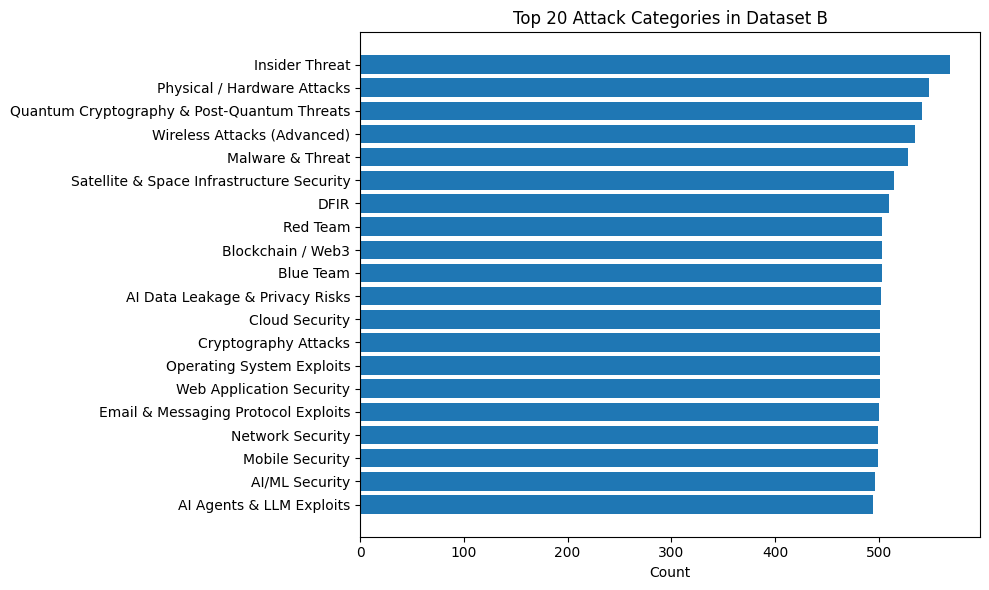

In [6]:
# Visualisation: Category distribution (top 20)
cat_counts = dfB["Category"].value_counts().head(20)

plt.figure(figsize=(10, 6))
plt.barh(cat_counts.index[::-1], cat_counts.values[::-1])
plt.xlabel("Count")
plt.title("Top 20 Attack Categories in Dataset B")
plt.tight_layout()
plt.show()


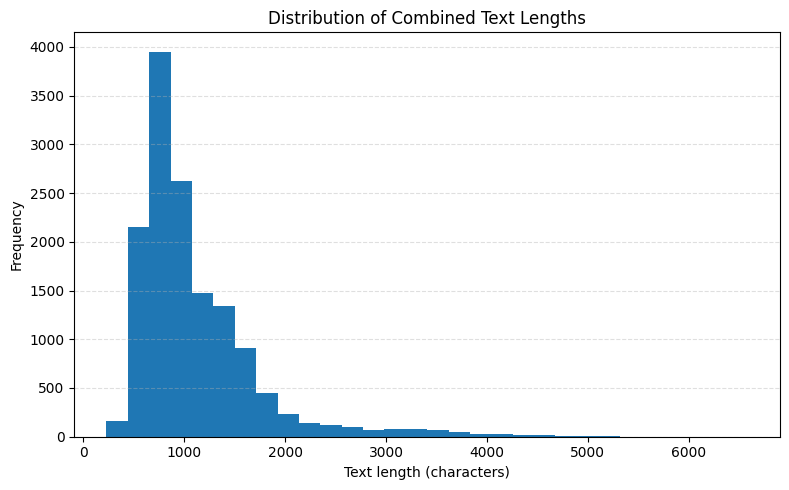

In [7]:
# Visualisation: Text length distribution
text_lengths = dfB["text"].str.len()

plt.figure(figsize=(8, 5))
plt.hist(text_lengths, bins=30)
plt.xlabel("Text length (characters)")
plt.ylabel("Frequency")
plt.title("Distribution of Combined Text Lengths")
plt.grid(axis="y", linestyle="--", alpha=0.4)
plt.tight_layout()
plt.show()

In [8]:
# Filter out very rare categories (with fewer than 2 samples)

# Work directly from dfB so indices line up
category_counts = dfB["Category"].value_counts()
print("Total categories before filtering:", len(category_counts))

# Keep categories that appear at least 2 times
valid_categories = category_counts[category_counts >= 2].index

# Filter dfB using .isin on the Category column
dfB_filtered = dfB[dfB["Category"].isin(valid_categories)].copy()

# Reset index so everything is clean and aligned
dfB_filtered = dfB_filtered.reset_index(drop=True)

print("Total categories after filtering:", dfB_filtered["Category"].nunique())
print("Total samples after filtering:", len(dfB_filtered))

# Define X_text and y from the filtered dataframe
X_text = dfB_filtered["text"]
y = dfB_filtered["Category"]


Total categories before filtering: 64
Total categories after filtering: 63
Total samples after filtering: 14132


In [9]:
# Train/test split 
from sklearn.model_selection import train_test_split

X_train_text, X_test_text, y_train, y_test = train_test_split(
    X_text,
    y,
    test_size=0.2,
    random_state=RANDOM_STATE,
    stratify=y,
)

X_train_text.shape, X_test_text.shape

((11305,), (2827,))

In [10]:
# TF–IDF vectorisation
tfidf = TfidfVectorizer(
    min_df=5,
    max_features=5000,
    ngram_range=(1, 2),
)

X_train = tfidf.fit_transform(X_train_text)
X_test = tfidf.transform(X_test_text)

X_train.shape, X_test.shape


((11305, 5000), (2827, 5000))

In [26]:
# Evaluation helper
def evaluate_multiclass(y_true, y_pred, average="macro"):
    acc = accuracy_score(y_true, y_pred)
    f1_macro = f1_score(y_true, y_pred, average="macro")
    f1_weighted = f1_score(y_true, y_pred, average="weighted")

    print(f"Accuracy:      {acc:.3f}")
    print(f"F1 (macro):    {f1_macro:.3f}")
    print(f"F1 (weighted): {f1_weighted:.3f}")
    print("\nClassification report:")
    print(classification_report(y_true, y_pred, digits=3))

    return acc, f1_macro, f1_weighted

In [19]:
# Logistic Regression (multiclass)
log_reg_mc = LogisticRegression(
    max_iter=2000,
    multi_class="multinomial",
    solver="saga",
    n_jobs=-1,
)

log_reg_mc.fit(X_train, y_train)
y_pred_lr = log_reg_mc.predict(X_test)

print("=== Logistic Regression (Multiclass) ===")
acc_lr, f1_macro_lr, f1_weighted_lr = evaluate_multiclass(y_test, y_pred_lr)


/opt/anaconda3/envs/tf-env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


=== Logistic Regression (Multiclass) ===
Accuracy:      0.829
F1 (macro):    0.524
F1 (weighted): 0.818

Classification report:
                                                                                                             precision    recall  f1-score   support

                                                                                   AI Agents & LLM Exploits      0.895     0.859     0.876        99
                                                                            AI Data Leakage & Privacy Risks      0.826     0.950     0.884       100
                                                                                             AI/ML Security      0.902     0.838     0.869        99
                                                                                           Automotive / CPS      0.000     0.000     0.000         2
                                                      Automotive / CPS → Firmware Over-The-Air (FOTA) Abuse      0.000     0.0

/opt/anaconda3/envs/tf-env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/opt/anaconda3/envs/tf-env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/opt/anaconda3/envs/tf-env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result

In [21]:
# Linear SVM
svm_clf = LinearSVC(
    random_state=RANDOM_STATE,
    class_weight="balanced"
)

svm_clf.fit(X_train, y_train)
y_pred_svm = svm_clf.predict(X_test)

print("=== Linear SVM ===")
acc_svm, f1_macro_svm, f1_weighted_svm = evaluate_multiclass(y_test, y_pred_svm)


=== Linear SVM ===
Accuracy:      0.871
F1 (macro):    0.630
F1 (weighted): 0.867

Classification report:
                                                                                                             precision    recall  f1-score   support

                                                                                   AI Agents & LLM Exploits      0.890     0.899     0.894        99
                                                                            AI Data Leakage & Privacy Risks      0.874     0.970     0.919       100
                                                                                             AI/ML Security      0.905     0.869     0.887        99
                                                                                           Automotive / CPS      0.000     0.000     0.000         2
                                                      Automotive / CPS → Firmware Over-The-Air (FOTA) Abuse      0.000     0.000     0.000         1

/opt/anaconda3/envs/tf-env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/opt/anaconda3/envs/tf-env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/opt/anaconda3/envs/tf-env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result

In [16]:
# MLPClassifier as deep model
mlp_mc = MLPClassifier(
    hidden_layer_sizes=(256, 128),
    activation="relu",
    solver="adam",
    alpha=1e-4,
    batch_size=64,
    learning_rate_init=1e-3,
    max_iter=30,         
    random_state=RANDOM_STATE,
    verbose=True,
)

mlp_mc.fit(X_train, y_train)
y_pred_mlp = mlp_mc.predict(X_test)

print("=== MLP (Neural Net) ===")
acc_mlp, f1_macro_mlp, f1_weighted_mlp = evaluate_multiclass(y_test, y_pred_mlp)

Iteration 1, loss = 2.38933398
Iteration 2, loss = 0.67246180
Iteration 3, loss = 0.31123794
Iteration 4, loss = 0.15940501
Iteration 5, loss = 0.09158100
Iteration 6, loss = 0.05318441
Iteration 7, loss = 0.03353390
Iteration 8, loss = 0.02296280
Iteration 9, loss = 0.01687693
Iteration 10, loss = 0.01342025
Iteration 11, loss = 0.01142484
Iteration 12, loss = 0.01018950
Iteration 13, loss = 0.00932512
Iteration 14, loss = 0.00873141
Iteration 15, loss = 0.00828011
Iteration 16, loss = 0.00792649
Iteration 17, loss = 0.00763961
Iteration 18, loss = 0.00740198
Iteration 19, loss = 0.00720416
Iteration 20, loss = 0.00702329
Iteration 21, loss = 0.00686104
Iteration 22, loss = 0.00670692
Iteration 23, loss = 0.00656695
Iteration 24, loss = 0.00642679
Iteration 25, loss = 0.00628816
Iteration 26, loss = 0.00615381
Iteration 27, loss = 0.00601787
Iteration 28, loss = 0.00588133
Iteration 29, loss = 0.00574636
Iteration 30, loss = 0.00560827
=== MLP (Neural Net) ===
Accuracy:      0.868
F1 

/opt/anaconda3/envs/tf-env/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (30) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/anaconda3/envs/tf-env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/opt/anaconda3/envs/tf-env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/opt/anaconda3/envs/tf-env/lib/python3.10/site-packages/sklearn/metrics/_classific

In [22]:
# Summary table for Stage 2 models
results_stage2 = pd.DataFrame(
    [
        ["Logistic Regression", acc_lr, f1_macro_lr, f1_weighted_lr],
        ["Linear SVM", acc_svm, f1_macro_svm, f1_weighted_svm],
        ["MLP", acc_mlp, f1_macro_mlp, f1_weighted_mlp],
    ],
    columns=["Model", "Accuracy", "F1_macro", "F1_weighted"],
).set_index("Model")

results_stage2


,Accuracy,F1_macro,F1_weighted
Model,,,
Logistic Regression,0.828794,0.523893,0.818113
Linear SVM,0.870534,0.629799,0.867496
MLP,0.868058,0.620582,0.864215


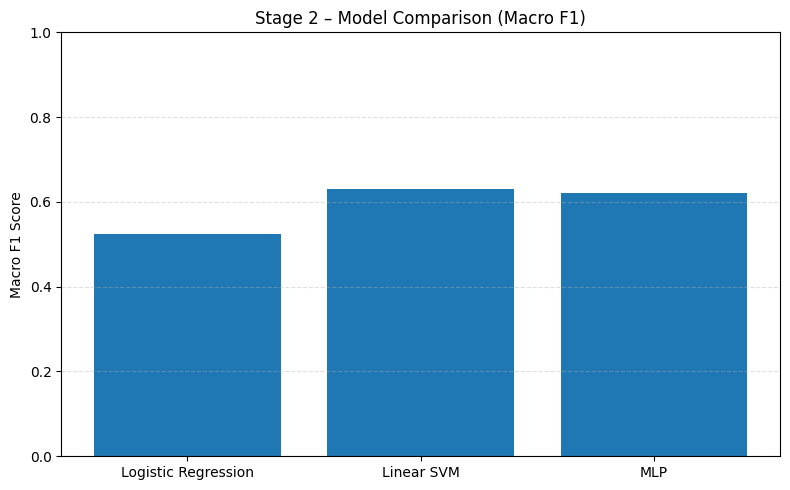

In [23]:
# Visualisation: Stage 2 model comparison (macro F1)
models = results_stage2.index.tolist()
f1_macros = results_stage2["F1_macro"].values

plt.figure(figsize=(8, 5))
plt.bar(models, f1_macros)
plt.ylabel("Macro F1 Score")
plt.title("Stage 2 – Model Comparison (Macro F1)")
plt.ylim(0, 1)
plt.grid(axis="y", linestyle="--", alpha=0.4)
plt.tight_layout()
plt.show()

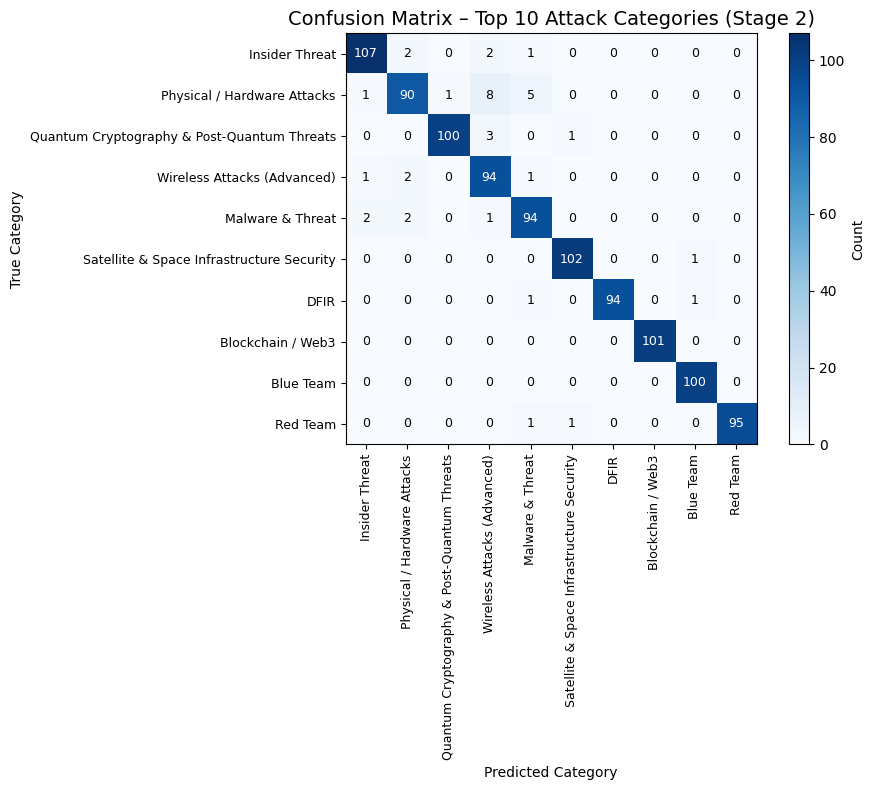

In [27]:
# 
from collections import Counter
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Building top-10 confusion matrix

y_pred_best = y_pred_svm  

# Top 10 categories based on frequency
test_counts = Counter(y_test)
top10_cats = [cat for cat, _ in test_counts.most_common(10)]

mask_top10 = y_test.isin(top10_cats)

y_test_top10 = y_test[mask_top10]
y_pred_top10 = pd.Series(y_pred_best, index=y_test.index)[mask_top10]

cm_top10 = confusion_matrix(y_test_top10, y_pred_top10, labels=top10_cats)


# for Clearer Plot

plt.figure(figsize=(10, 8))
plt.imshow(cm_top10, cmap="Blues", interpolation="nearest")
plt.colorbar(label="Count")

plt.xticks(range(len(top10_cats)), top10_cats, rotation=90, fontsize=9)
plt.yticks(range(len(top10_cats)), top10_cats, fontsize=9)

plt.title("Confusion Matrix – Top 10 Attack Categories (Stage 2)", fontsize=14)
plt.xlabel("Predicted Category")
plt.ylabel("True Category")

# Add text annotations on each cell
threshold = cm_top10.max() / 2
for i in range(len(top10_cats)):
    for j in range(len(top10_cats)):
        cell_value = cm_top10[i, j]
        color = "white" if cell_value > threshold else "black"
        plt.text(
            j, i, str(cell_value),
            ha="center", va="center",
            color=color, fontsize=9
        )

plt.tight_layout()
plt.show()


In [25]:
# Save Stage 2 TF-IDF vectoriser and SVM model
import joblib

joblib.dump(tfidf, "stage2_tfidf.pkl")
joblib.dump(svm_clf, "stage2_svm.pkl")

print("Saved stage2_tfidf.pkl and stage2_svm.pkl")


Saved stage2_tfidf.pkl and stage2_svm.pkl
